In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=78b9665eaed4dbeefe9a17150c9e690bf5fd418b0f2178300adbaeeda751dcde
  Stored in directory: /root/.cache/pip/wheels/0d/17/90/042948fd2e2a87f1dcf6db6d438cad015c49db0c53d1d9c7dc
Successfully built openai-clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which i

In [18]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset('Soumyajit9979/animals-humans')

README.md:   0%|          | 0.00/2.45k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00002.parquet:   0%|          | 0.00/555M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00001-of-00002.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6291 [00:00<?, ? examples/s]

In [19]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6291
    })
})

In [20]:
entry = ds['train'][0]
entry

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1640x1025>,
 'label': 0}

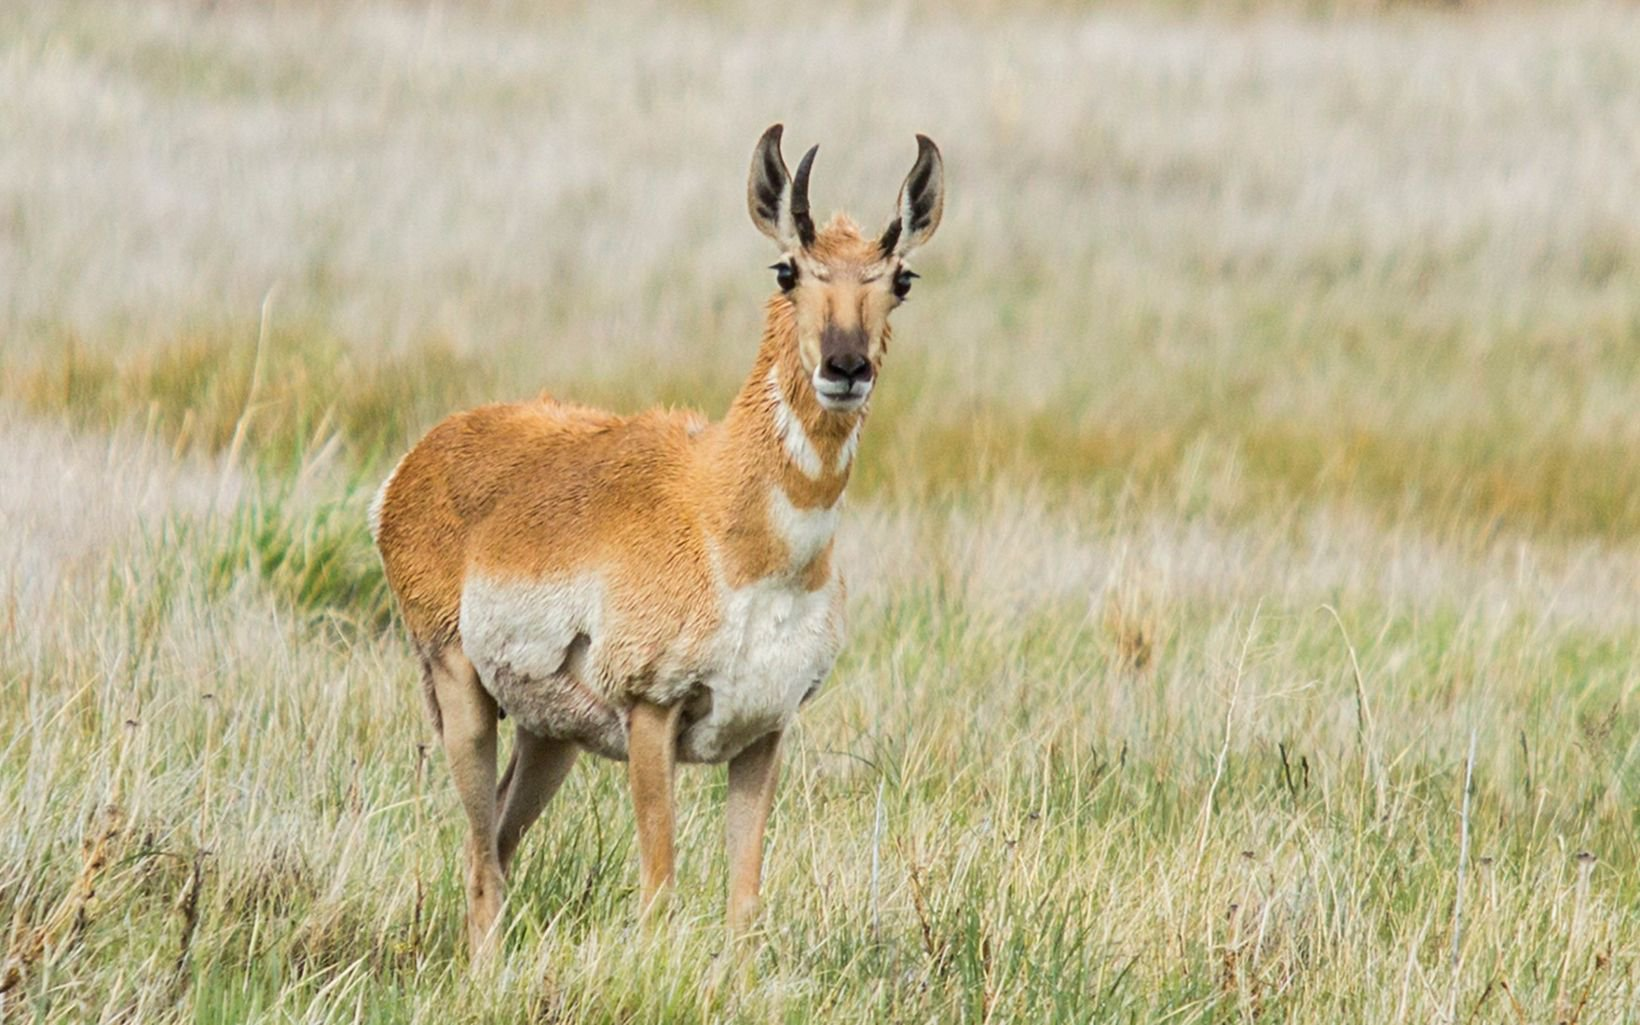

In [6]:
image = entry['image']
image

In [7]:
dataset = ds['train']

In [21]:
import clip
import torch

# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

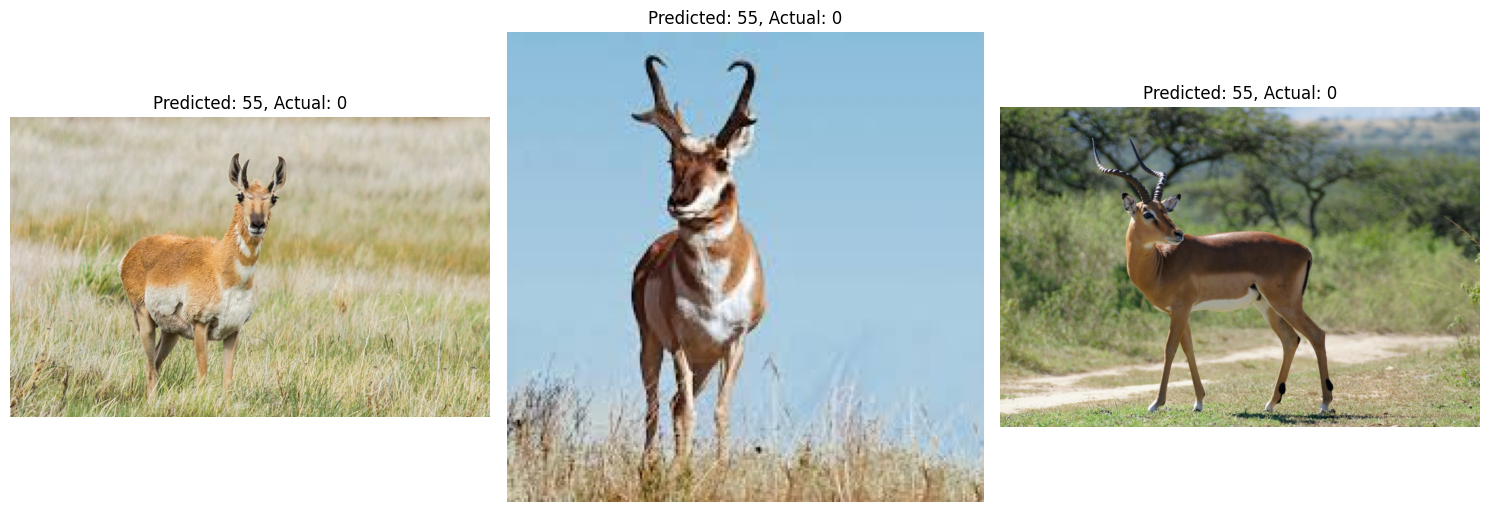

In [22]:
import matplotlib.pyplot as plt

# Select indices for three example images
indices = [0, 2, 10]

# Get the list of possible subcategories from the dataset
subcategories = list(set(example['label'] for example in dataset))

# Preprocess the text descriptions for each subcategory
text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in subcategories]).to(device)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Select an example image from the dataset
    example = dataset[idx]
    image = example['image']
    subcategory = example['label']

    # Preprocess the image
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Calculate image and text features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity between image and text features
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {subcategories[indices[0]]}, Actual: {subcategory}")
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [23]:
from torch.utils.data import random_split

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [24]:
from torchvision import transforms
from torch.utils.data import Dataset

# Define a custom dataset class
class FashionDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Lambda(lambda image: image.convert("RGB")),  # Convert grayscale to RGB
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                (0.26862954, 0.26130258, 0.27577711))
        ])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        subcategory = item['label']
        label = subcategories.index(subcategory)
        return self.transform(image), label

In [25]:
from torch.utils.data import DataLoader

# Create DataLoader for training and validation sets
train_loader = DataLoader(FashionDataset(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(FashionDataset(val_dataset), batch_size=32, shuffle=False)

In [26]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [27]:
num_classes = len(subcategories)
model_ft = CLIPFineTuner(model, num_classes).to(device)

In [28]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

In [29]:
from tqdm import tqdm

# Number of epochs for training
num_epochs = 15

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    print(f'Validation Accuracy: {100 * correct / total}%')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

Epoch 1/15, Loss: 4.3665: 100%|██████████| 145/145 [00:47<00:00,  3.06it/s]


Epoch [1/15], Loss: 4.3665
Validation Accuracy: 20.19064124783362%


Epoch 2/15, Loss: 3.9582: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch [2/15], Loss: 3.9582
Validation Accuracy: 60.22530329289428%


Epoch 3/15, Loss: 3.5813: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch [3/15], Loss: 3.5813
Validation Accuracy: 75.64991334488735%


Epoch 4/15, Loss: 3.2274: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch [4/15], Loss: 3.2274
Validation Accuracy: 80.93587521663778%


Epoch 5/15, Loss: 2.8965: 100%|██████████| 145/145 [00:47<00:00,  3.05it/s]


Epoch [5/15], Loss: 2.8965
Validation Accuracy: 84.40207972270363%


Epoch 6/15, Loss: 2.5927: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch [6/15], Loss: 2.5927
Validation Accuracy: 86.04852686308492%


Epoch 7/15, Loss: 2.3144: 100%|██████████| 145/145 [00:47<00:00,  3.07it/s]


Epoch [7/15], Loss: 2.3144
Validation Accuracy: 87.6949740034662%


Epoch 8/15, Loss: 2.0658: 100%|██████████| 145/145 [00:47<00:00,  3.07it/s]


Epoch [8/15], Loss: 2.0658
Validation Accuracy: 88.90814558058925%


Epoch 9/15, Loss: 1.8457: 100%|██████████| 145/145 [00:47<00:00,  3.07it/s]


Epoch [9/15], Loss: 1.8457
Validation Accuracy: 89.60138648180242%


Epoch 10/15, Loss: 1.6510: 100%|██████████| 145/145 [00:47<00:00,  3.07it/s]


Epoch [10/15], Loss: 1.6510
Validation Accuracy: 90.46793760831889%


Epoch 11/15, Loss: 1.4831: 100%|██████████| 145/145 [00:46<00:00,  3.09it/s]


Epoch [11/15], Loss: 1.4831
Validation Accuracy: 90.72790294627383%


Epoch 12/15, Loss: 1.3361: 100%|██████████| 145/145 [00:47<00:00,  3.07it/s]


Epoch [12/15], Loss: 1.3361
Validation Accuracy: 92.11438474870018%


Epoch 13/15, Loss: 1.2131: 100%|██████████| 145/145 [00:47<00:00,  3.07it/s]


Epoch [13/15], Loss: 1.2131
Validation Accuracy: 92.54766031195841%


Epoch 14/15, Loss: 1.1005: 100%|██████████| 145/145 [00:47<00:00,  3.07it/s]


Epoch [14/15], Loss: 1.1005
Validation Accuracy: 92.80762564991335%


Epoch 15/15, Loss: 1.0055: 100%|██████████| 145/145 [00:47<00:00,  3.05it/s]


Epoch [15/15], Loss: 1.0055
Validation Accuracy: 92.89428076256499%
